In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal

In [2]:
data_1=pd.read_csv('data_1.csv')

In [3]:
data_1

,Frequency [MHz],Weight,a: Tsky [K],b: Tres1 [K],c: Tres2 [K],d: Tmodel [K],e: T21 [K]
0,50.012207,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,50.402832,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,50.793457,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,51.184082,1,4645.468619,-0.034440,-0.099255,0.000000,-0.099255
4,51.574707,1,4556.501107,0.071895,0.021244,0.000000,0.021244
...,...,...,...,...,...,...,...
123,98.059082,1,877.642853,-0.169377,0.006739,-0.000103,0.006636
124,98.449707,1,868.701882,-0.181803,0.018884,-0.000068,0.018816
125,98.840332,1,859.822813,-0.259145,-0.033581,-0.000044,-0.033625
126,99.230957,0,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
freq=data_1.iloc[:,0]
T =data_1.iloc[:,-1]
model = data_1.iloc[:, -2]

In [5]:
def func (x, a,b,c,h):
    return -c*(1/(1+np.exp(-a*(x-h))))*(1/(1+np.exp(a*(x-b-h))))
# a is the magnitude of depth
#b is the width of depth
#c is a mulitiplication
#h is the horizontal place of depth


def gaussian (x,a,b,h):
    return a*np.exp(-((a-h)/(2*b))**2)

def chisquare (fobs,fexp):
    return np.sum((fobs-fexp)**2)

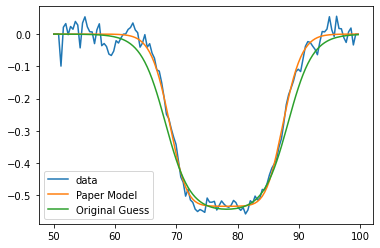

In [6]:
plt.plot(freq, T, label='data')
plt.plot(freq, model, label='Paper Model')
plt.plot(freq, func(freq,0.5,20,0.55,68.2), label='Original Guess')
plt.legend()
plt.show()

In [7]:
def mcmc (max_steps, start_guess):
    #the step counter
    i = 0
    
    #definig the chain
    chain = np.empty((max_steps, 4))
    chain[0, :] = start_guess
    
    #defining the chi-square
    chisq = np.empty(max_steps)
    chisq[0] = chisquare(func(freq, start_guess[0], start_guess[1], start_guess[2], start_guess[3]), T)
    
    #the chain 
    for i in range(1,max_steps):
        new_param = normal(chain[i-1], 0.005)
        new_chisq = chisquare(func(freq, new_param[0], new_param[1], new_param[2], new_param[3]),T)
        
        #If chi-square gets big, we should do another step
        if new_chisq >= chisq[i-1]:
            prob = np.exp(-0.5*(new_chisq-chisq[i-1]))
            if np.random.rand() >= prob:
                chisq[i] = new_chisq
                chain[i, :] = new_param
                
            else:
                chisq[i] = chisq[i-1]
                chain[i, :] = chain[i-1, :]
                
        #if chi-square got small, we accept it        
        else:
            chisq[i] = new_chisq
            chain[i, :] = new_param
            
    return chain, chisq


In [8]:
start_guess = [0.5,20,0.55,70]
params, cs = mcmc(10000, start_guess)

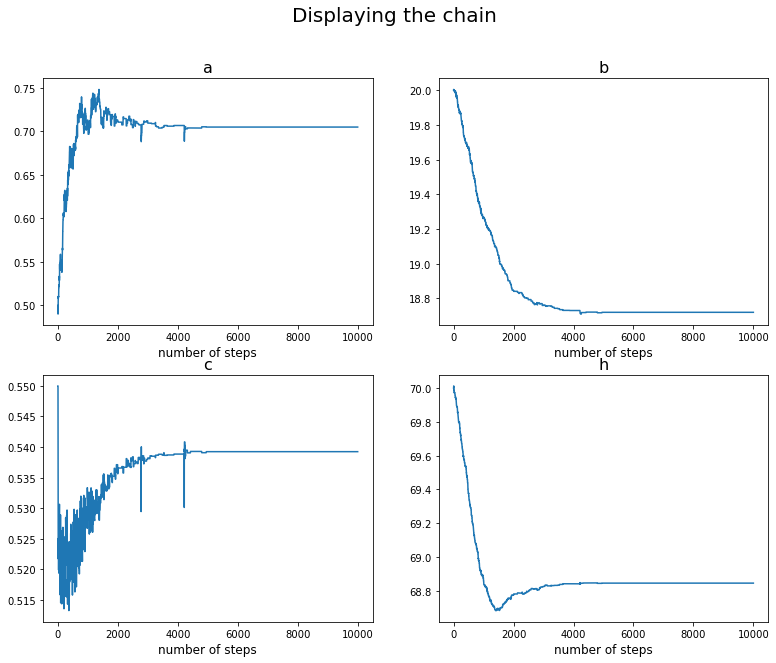

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,10))
fig.suptitle('Displaying the chain', fontsize=20)
ax1.plot(params[:, 0])
ax1.set_title('a', fontsize=16)
ax1.set_xlabel('number of steps', fontsize=12)

ax2.plot(params[:, 1])
ax2.set_title('b', fontsize=16)
ax2.set_xlabel('number of steps', fontsize=12)

ax3.plot(params[:, 2])
ax3.set_title('c', fontsize=16)
ax3.set_xlabel('number of steps', fontsize=12)

ax4.plot(params[:, 3])
ax4.set_title('h', fontsize=16)
ax4.set_xlabel('number of steps', fontsize=12)

plt.show()


In [10]:
mcmc_result_0 = np.mean(params[:,0])
mcmc_result_1 = np.mean(params[:,1])
mcmc_result_2 = np.mean(params[:,2])
mcmc_result_3 = np.mean(params[:,3])

In [11]:
print('a: ', mcmc_result_0,', b: ', mcmc_result_1,', c: ', mcmc_result_2,', h :', mcmc_result_3)
print("Chi squared of mcmc:",chisquare(func(freq, mcmc_result_0, mcmc_result_1, mcmc_result_2, mcmc_result_3),T))
print("Chi squared of original guess:",chisquare(func(freq,start_guess[0], start_guess[1], start_guess[2], start_guess[3]),T))

a:  0.7022632315292692 , b:  18.854821667730366 , c:  0.5367430906140436 , h : 68.88333703664152
Chi squared of mcmc: 0.07776386740242082
Chi squared of original guess: 0.6571934236694024


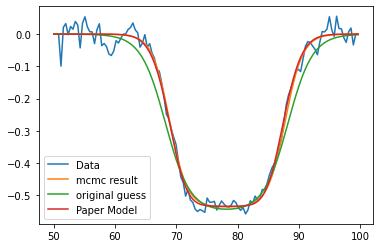

In [12]:
fig2 = plt.figure()
plt.plot(freq, T, label='Data')
plt.plot(freq, func(freq, mcmc_result_0, mcmc_result_1, mcmc_result_2, mcmc_result_3), label="mcmc result")
plt.plot(freq, func(freq,0.5,20,0.55,68.2), label="original guess")
plt.plot(freq, model, label='Paper Model')
plt.legend()
#plt.ylim(top=-0.4)
#plt.xlim(65,90)
plt.show()
